# Introduction

Gun ownership in the United States of America (USA) is legal and constitutionally protected by the United States Bill of Rights. The Second Amendment of the United States Constitution states that "A well regulated Militia, being necessary to the security of a free State, the right of the people to keep and bear Arms, shall not be infringed." This amendment protects the right of law-abiding citizens to use firearms as a tool of self-defence. However, the circulation and possesion of firearms also poses an increased potential hazard to the life and wellbeing American citizens, as accidental or intentional discharges can imperil their lives. Consequently, a series of gun laws have been enacted throughout the years to prevent gun violence incidents from occuring.

The present notebook aims to analyse gun violence trends in the United States from January 2013 to March 2018, as well as the efficacy of gun laws throughout this period. The data used throughout this notebook has been obtained from the Gun Violence Archive (GVA), and made available by James Ko. GVA is a non-profit research group founded in 2013, whose goal is to provide accurate information about gun violence incidents to the public. The data is collected from over 6,500 law enforcement, media, government and commercial sources daily, and uploaded to their website (https://gunviolencearchive.org) in real-time, as well as used for statistics on their social platforms. GVA does not have any affiliation with an organisation or political party.

# Data Exploration

The data provided by GVA contains 239,677 recorded incidents from January 2013 to March 2018, presented in increasing chronological order. The raw dataset contains 29 features which exhibit information about the time, location, and participants of the event, as well as sources to confirm its veridicality. The features presented in the dataset, together with their corresponding data types and descriptions, are as follows:

1. **address**: address of the location of the attack
2. **city_or_county**: city/county of the attack
3. **congressional_district**: the congressional district the attack occured under
4. **date**: date in format "YYYY-MM-DD"
5. **gun_stolen**: boolean values indicating whether each gun used in the attack was stolen, stored in a dictionary format
6. **gun_type**: type of each gun used in the attack in a dictionary format
7. **incident_characteristics**: characteristics of the incident, in a list format	
8. **incident_id**: GVA unique identification number of incident
9. **incident_url**: GVA URL corresponding to the incident
10. **incident_url_fields_missing**: boolean indicating whether the incident URL field is missing
11. **latitude**: latitude of the location of the attach
12. **location_description**: characteristics of the location of the attack
13. **longitude**: longitude of the location of the attach
14. **n_guns_involved**: number of guns involved in the attack
15. **n_injured**: total number of people injured in the attack	
16. **n_killed**: total number of people killed in the attack
17. **notes**: miscellaneous notes about the incident
18. **participant_age**: the ages of the participants involved in the attack
19. **participant_age_group**: the age groups the participants involved in the attack fall within; possible values are:
    1. Child 0-11
    2. Teen 12-17
    3. Adult 18+ 
20. **participant_gender**: the genders of the participants involved in the attack
21. **participant_name**: the names of the participants involved in the attack
22. **participant_relationship**: the relationships between the suspect and the victims of the attack; possible values are: 
    1. 'Home Invasion - Perp Does Not Know Victim'
    2. 'Neighbor'
    3. 'Drive by - Random victims'
    4. 'Friends'
    5. 'Significant others - current or former'
    6. 'Gang vs Gang'
    7. 'Armed Robbery'
    8. 'Home Invasion - Perp Knows Victim'
    9. 'Mass shooting - Random victims'
    10. 'Aquaintance'
    11. 'Mass shooting - Perp Knows Victims'
    12. 'Co-worker'
    13. 'Family' 
23. **participant_status**: extent of harm done to the participants of the attack; possible values are:
    1. Killed
    2. Injured
    3. Unharmed
    4. Arrested
24. **participant_type**: type of the participant, e.g. victim, suspect, etc.
25. **source_url**: URL used as a primary source for the data
26. **sources**: reporting sources
27. **state**: state of the crime
28. **state_house_district**: voting house district
29. **state_senate_district**: territorial district from which a senator to a state legislature is elected

In [1]:
# plot incidents on lon/lat map for mass shootings
# plot incidents on lon/lat map with scale wrt n_casualties for mass shootings
# location description plot of the most frequent

# separate analysis for underage shooters
# separate analysis for killed/injured teens or kids
# separate analysis for gender
# train a model to predict the age of victims?
# dimensionality reduction?
# timeseries predictions?

In [2]:
import pandas as pd
import numpy as np
import Levenshtein as lev
import random
from scipy.stats import skew
import missingno as msno
from datetime import datetime as dt
import data_exploration as de

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [5]:
incidents = pd.read_csv("gun-violence-data_01-2013_03-2018.csv")

As notified by James Ko, the Las Vegas mass shooting incident from 2017 is missing from the original dataset. A separate .csv file is then provided and merged to the raw data.

In [6]:
# Add the Las Vegas shooting incident from 2017
lv_incident = pd.read_csv("las-vegas-1-10-2017.csv")
incidents = pd.concat([incidents, lv_incident])

In [7]:
incidents.shape

(239678, 29)

In [8]:
incidents.head(3)

,incident_id,date,state,city_or_county,address,n_killed,n_injured,incident_url,source_url,incident_url_fields_missing,congressional_district,gun_stolen,gun_type,incident_characteristics,latitude,location_description,longitude,n_guns_involved,notes,participant_age,participant_age_group,participant_gender,participant_name,participant_relationship,participant_status,participant_type,sources,state_house_district,state_senate_district
0,461105,2013-01-01,Pennsylvania,Mckeesport,1506 Versailles Avenue and Coursin Street,0,4,http://www.gunviolencearchive.org/incident/461105,http://www.post-gazette.com/local/south/2013/0...,False,14.0,NaN,NaN,Shot - Wounded/Injured||Mass Shooting (4+ vict...,40.3467,NaN,-79.8559,NaN,Julian Sims under investigation: Four Shot and...,0::20,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male||1::Male||3::Male||4::Female,0::Julian Sims,NaN,0::Arrested||1::Injured||2::Injured||3::Injure...,0::Victim||1::Victim||2::Victim||3::Victim||4:...,http://pittsburgh.cbslocal.com/2013/01/01/4-pe...,NaN,NaN
1,460726,2013-01-01,California,Hawthorne,13500 block of Cerise Avenue,1,3,http://www.gunviolencearchive.org/incident/460726,http://www.dailybulletin.com/article/zz/201301...,False,43.0,NaN,NaN,"Shot - Wounded/Injured||Shot - Dead (murder, a...",33.9090,NaN,-118.3330,NaN,Four Shot; One Killed; Unidentified shooter in...,0::20,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male,0::Bernard Gillis,NaN,0::Killed||1::Injured||2::Injured||3::Injured,0::Victim||1::Victim||2::Victim||3::Victim||4:...,http://losangeles.cbslocal.com/2013/01/01/man-...,62.0,35.0
2,478855,2013-01-01,Ohio,Lorain,1776 East 28th Street,1,3,http://www.gunviolencearchive.org/incident/478855,http://chronicle.northcoastnow.com/2013/02/14/...,False,9.0,0::Unknown||1::Unknown,0::Unknown||1::Unknown,"Shot - Wounded/Injured||Shot - Dead (murder, a...",41.4455,Cotton Club,-82.1377,2.0,NaN,0::25||1::31||2::33||3::34||4::33,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male||1::Male||2::Male||3::Male||4::Male,0::Damien Bell||1::Desmen Noble||2::Herman Sea...,NaN,"0::Injured, Unharmed, Arrested||1::Unharmed, A...",0::Subject-Suspect||1::Subject-Suspect||2::Vic...,http://www.morningjournal.com/general-news/201...,56.0,13.0


## Data cleaning

In this section we have perfomed the following:
1. drop features irrelevant to the analysis
2. converted the **date** features to type datetime
3. converted string dictionaries to Python dictionaries in **participant_** fields
4. convert string lists to Python lists in **incident_characteristics**
5. cleaned **address** values for typos or inconsistencies in format

In [9]:
# incidents.set_index("incident_id", inplace=True)
incidents = incidents.drop(["incident_url_fields_missing", "incident_url", "source_url", "sources"], axis=1)

In [10]:
incidents["date"] = pd.to_datetime(incidents["date"])
incidents = incidents.sort_values(by=["date"])

In [11]:
for col in ['gun_stolen', 'gun_type', 'participant_name', 'participant_age', 'participant_age_group', 'participant_gender', 'participant_relationship', 'participant_status', 'participant_type']:
    incidents[col] = incidents[col].apply(de.split_into_dict)
incidents['participant_age'] = incidents['participant_age'].apply(de.convert_vals_to_int)
incidents['incident_characteristics'] = incidents['incident_characteristics'].apply(de.split_into_list)

In [80]:
# Function to remove house/street numbers from address
def clean_unique_address(address):
    # Remove orders
    address = re.sub('([0-9]*th|[0-9]*1st|[0-9]*2nd|[0-9]*3rd)', ' ', address)
    # Remove digits
    address = re.sub('[0-9]*', '', address)
    # Remove cardinal points
    address = re.sub('N |E |S |W |NE|NW|SE|SW', ' ', address)
    # Clean whitespaces
    address = clean_whitespaces(address)
    return address

In [81]:
# Compare addresses only after removing numbers to ensure that the dissimilarity is not caused by houses/streets of different numbers
lev_addresses = dict()
for item in list(set(data[pd.notnull(data['Address'])]["Address"].apply(clean_address_string))):
    lev_addresses[index] = clean_unique_address(item)
    index += 1

In [83]:
# Sample 1% of the addresses
lev_addresses = dict(random.sample(lev_addresses.items(), 1884))

In [443]:
# Find combinations of addresses that have between 0.95 and 0.99 similarity, disregarding numbers of streets and cardinals
for sampled_address in sample_lev_addresses.keys():
    for address in unique_addresses.keys():
        similarity = lev.ratio(lev_addresses[sampled_address], lev_addresses[address])
        if similarity*100 in range(95, 100):
            print("There is a similarity of " + str(similarity) + " between the following strings:")
            print(" 1. " + unique_addresses[sampled_address])
            print(" 2. " + unique_addresses[address])

There is a similarity of 0.95 between the following strings:
 1. 1800 block of Amber Drive
 2. 3000 block of Ember Drive
There is a similarity of 0.96 between the following strings:
 1. N Clark Street
 2. 1812 W Clarke Street
There is a similarity of 0.96 between the following strings:
 1. N Clark Street
 2. 1820 W Clarke Street
There is a similarity of 0.96 between the following strings:
 1. N Clark Street
 2. Clarke Street
There is a similarity of 0.96 between the following strings:
 1. N Clark Street
 2. 1617 W Clarke Street
There is a similarity of 0.96 between the following strings:
 1. N Clark Street
 2. 3900 Clarke Street
There is a similarity of 0.95 between the following strings:
 1. 1000 block of Eagle Drive
 2. 1950 block of Cagle Drive
There is a similarity of 0.96 between the following strings:
 1. 202 W Baker Street
 2. 185 Barker Street
There is a similarity of 0.96 between the following strings:
 1. 202 W Baker Street
 2. 75 Barker Street
There is a similarity of 0.96 b

There is a similarity of 0.96 between the following strings:
 1. 304 Waters Avenue
 2. S Water Avenue
There is a similarity of 0.96 between the following strings:
 1. 304 Waters Avenue
 2. Water Avenue
There is a similarity of 0.96 between the following strings:
 1. 304 Waters Avenue
 2. NW Water Avenue
There is a similarity of 0.96 between the following strings:
 1. 6400 block of S Claremont Avenue
 2. 2900 block of Clairmont Avenue
There is a similarity of 0.95 between the following strings:
 1. 2200 block of Poland Road
 2. 8300 block of Noland Road
There is a similarity of 0.95 between the following strings:
 1. 2200 block of Poland Road
 2. 9700 block of Noland Road
There is a similarity of 0.95 between the following strings:
 1. 2200 block of Poland Road
 2. 1100 block of N Noland Road
There is a similarity of 0.95 between the following strings:
 1. 1100 block of Oster Drive
 2. 100 block of Otero Drive
There is a similarity of 0.95 between the following strings:
 1. 1100 block o

There is a similarity of 0.96 between the following strings:
 1. 800 block of Martin Luther King Boulevard
 2. 300 block of Martin Luther King Jr Boulevard
There is a similarity of 0.96 between the following strings:
 1. 800 block of Martin Luther King Boulevard
 2. 2600 block of Martin Luther King Jr Boulevard SW
There is a similarity of 0.96 between the following strings:
 1. 800 block of Martin Luther King Boulevard
 2. 100 block of Martin Luther King Jr Boulevard
There is a similarity of 0.96 between the following strings:
 1. 800 block of Martin Luther King Boulevard
 2. 300 block of N Martin Luther King Jr Boulevard
There is a similarity of 0.96 between the following strings:
 1. 800 block of Martin Luther King Boulevard
 2. 800 block of S Martin Luther King Jr Boulevard
There is a similarity of 0.96 between the following strings:
 1. 800 block of Martin Luther King Boulevard
 2. 600 block of Martin Luther King Jr Boulevard
There is a similarity of 0.96 between the following stri

There is a similarity of 0.95 between the following strings:
 1. 1700 block of Eden Avenue
 2. 10300 block of Edes Avenue
There is a similarity of 0.95 between the following strings:
 1. 1700 block of Eden Avenue
 2. 8400 block of Edes Avenue
There is a similarity of 0.95 between the following strings:
 1. 1700 block of Eden Avenue
 2. 2300 block of Edna Avenue
There is a similarity of 0.95 between the following strings:
 1. 1700 block of Eden Avenue
 2. 5900 block of Edna Avenue
There is a similarity of 0.95 between the following strings:
 1. 1700 block of Eden Avenue
 2. 9800 block of Edes Avenue
There is a similarity of 0.95 between the following strings:
 1. 1700 block of Eden Avenue
 2. 10400 block of Edes Avenue
There is a similarity of 0.96 between the following strings:
 1. 615 N Hawley Street
 2. Haley Street
There is a similarity of 0.96 between the following strings:
 1. 512 S Kings Highway
 2. 5937 King Highway
There is a similarity of 0.96 between the following strings:
 1

There is a similarity of 0.95 between the following strings:
 1. 2600 block of Eighth Street NE
 2. 3100 block of High Street
There is a similarity of 0.95 between the following strings:
 1. 2600 block of Eighth Street NE
 2. 200 block of High Street
There is a similarity of 0.95 between the following strings:
 1. 2600 block of Eighth Street NE
 2. 1700 block of High Street
There is a similarity of 0.95 between the following strings:
 1. 2600 block of Eighth Street NE
 2. 10000 block of High Street
There is a similarity of 0.95 between the following strings:
 1. 2600 block of Eighth Street NE
 2. 400 block of High Street
There is a similarity of 0.95 between the following strings:
 1. 2600 block of Eighth Street NE
 2. 3400 block of High Street
There is a similarity of 0.95 between the following strings:
 1. 2600 block of Eighth Street NE
 2. 1100 block of E High Street
There is a similarity of 0.95 between the following strings:
 1. 2600 block of Eighth Street NE
 2. 900 block of High

There is a similarity of 0.96 between the following strings:
 1. 6422 Storer Avenue
 2. 92 Store Avenue
There is a similarity of 0.95 between the following strings:
 1. 1800 block of Pryor Street
 2. 4200 block of Pro Street
There is a similarity of 0.95 between the following strings:
 1. 1500 block of SW Polk Street
 2. 300 block of Folk Street
There is a similarity of 0.96 between the following strings:
 1. Cricket Lane
 2. 20 Crickett Lane
There is a similarity of 0.96 between the following strings:
 1. Elliot Street
 2. 36 Eliot Street
There is a similarity of 0.95 between the following strings:
 1. 500 block of Iowa Avenue
 2. 3200 block of Iola Avenue
There is a similarity of 0.96 between the following strings:
 1. 1214 Baker Avenue
 2. 4969 N Backer Avenue
There is a similarity of 0.96 between the following strings:
 1. 1214 Baker Avenue
 2. N Backer Avenue
There is a similarity of 0.96 between the following strings:
 1. 1214 Baker Avenue
 2. 273 Barker Avenue
There is a similar

In [12]:
incidents['address'] = incidents['address'].apply(de.clean_address_string)

## Dataset separation

Split the raw dataset in 3 datasets: one containing all **incidents** with incident characteristics as features, i.e. date, state, city/county etc., one containing all **guns** involved in the incidents, with type and origin as features, and lastly a dataset with all **participants** and their details (name, age, status etc.)

In [13]:
# Select only the features of interest from the dataset to speed up the process
df_guns = incidents[["gun_type", "gun_stolen", "incident_id"]].copy()

In [14]:
# Create a NumPy array to store gun information, then converting it to DataFrame for performance enhacement
guns_array = np.empty(shape=(int(incidents["n_guns_involved"].sum()), len(df_guns.columns)), dtype=object)
rows = df_guns.values
array_i = 0
for df_i in range(df_guns.shape[0]):
    if pd.notnull(rows[df_i][df_guns.columns.get_loc("gun_type")]):
        for k, v in rows[df_i][df_guns.columns.get_loc("gun_type")].items():
            if pd.notnull(rows[df_i][df_guns.columns.get_loc("gun_stolen")]):
                if k in rows[df_i][df_guns.columns.get_loc("gun_stolen")].keys():
                    guns_array[array_i][df_guns.columns.get_loc("gun_stolen")] = rows[df_i][df_guns.columns.get_loc("gun_stolen")][k]
            guns_array[array_i][df_guns.columns.get_loc("gun_type")] = v
            guns_array[array_i][df_guns.columns.get_loc("incident_id")] = rows[df_i][df_guns.columns.get_loc("incident_id")]
            array_i += 1
guns = pd.DataFrame(guns_array, columns=["type", "stolen", "incident_id"])

In [15]:
# Compute the total number of participants to initialise the NumPy array with the right size
n_participants = 0
for row in incidents.values:
    if pd.notnull(row[incidents.columns.get_loc("participant_type")]):
        n_participants += len(row[incidents.columns.get_loc("participant_type")])

In [16]:
df_participants = incidents[["participant_name", "participant_age", "participant_age_group", "participant_gender", "participant_relationship", "participant_status", "participant_type", "incident_id"]].copy()

In [17]:
participants_array = np.empty(shape=(n_participants, len(df_participants.columns)), dtype=object)
rows = df_participants.values
array_i = 0
for df_i in range(df_participants.shape[0]):
    if pd.notnull(rows[df_i][df_participants.columns.get_loc("participant_type")]):
        for k, v in rows[df_i][df_participants.columns.get_loc("participant_type")].items():
            if pd.notnull(rows[df_i][df_participants.columns.get_loc("participant_name")]):
                if k in rows[df_i][df_participants.columns.get_loc("participant_name")].keys():
                    participants_array[array_i][df_participants.columns.get_loc("participant_name")] = rows[df_i][df_participants.columns.get_loc("participant_name")][k]
            if pd.notnull(rows[df_i][df_participants.columns.get_loc("participant_age")]):
                if k in rows[df_i][df_participants.columns.get_loc("participant_age")].keys():
                    participants_array[array_i][df_participants.columns.get_loc("participant_age")] = rows[df_i][df_participants.columns.get_loc("participant_age")][k]
            if pd.notnull(rows[df_i][df_participants.columns.get_loc("participant_age_group")]):
                if k in rows[df_i][df_participants.columns.get_loc("participant_age_group")].keys():
                    # Some age_group values of the same value have different formats, i.e. "Teen (12-17)" and "Teen 12-17"
                    if rows[df_i][df_participants.columns.get_loc("participant_age_group")][k] == "Teen (12-17)":
                        participants_array[array_i][df_participants.columns.get_loc("participant_age_group")] = "Teen 12-17"
                    else:
                        participants_array[array_i][df_participants.columns.get_loc("participant_age_group")] = rows[df_i][df_participants.columns.get_loc("participant_age_group")][k]
            if pd.notnull(rows[df_i][df_participants.columns.get_loc("participant_gender")]):
                if k in rows[df_i][df_participants.columns.get_loc("participant_gender")].keys():
                    participants_array[array_i][df_participants.columns.get_loc("participant_gender")] = rows[df_i][df_participants.columns.get_loc("participant_gender")][k]
            if pd.notnull(rows[df_i][df_participants.columns.get_loc("participant_relationship")]):
                if k in rows[df_i][df_participants.columns.get_loc("participant_relationship")].keys():
                    participants_array[array_i][df_participants.columns.get_loc("participant_relationship")] = rows[df_i][df_participants.columns.get_loc("participant_relationship")][k]
            if pd.notnull(rows[df_i][df_participants.columns.get_loc("participant_status")]):
                if k in rows[df_i][df_participants.columns.get_loc("participant_status")].keys():
                    participants_array[array_i][df_participants.columns.get_loc("participant_status")] = rows[df_i][df_participants.columns.get_loc("participant_status")][k]
            participants_array[array_i][df_participants.columns.get_loc("participant_type")] = v
            participants_array[array_i][df_participants.columns.get_loc("incident_id")] = rows[df_i][df_participants.columns.get_loc("incident_id")]
            array_i += 1
            
participants = pd.DataFrame(participants_array, columns=["participant_name", "participant_age", "participant_age_group", "participant_gender", "participant_relationship", "participant_status", "participant_type", "incident_id"])

## Distribution of quantitative features

The number of casualties ranges from 0 to 59 for deaths, and from 0 to 441 for injuries respectively. Both values show a relatively high positive skewness ($\gamma_1$ = 11 and $\gamma_1$ = 230), revealing that incidents with few casualties are predominant in both instances. This can also be visualised in the table below, where the upper quartile (lowest 75%) of **n_killed** is 0, and of **n_injured** is 1. A plot of the two values needs to be constructed to better assess the distribution of these two variables. The dataset description also shows that incidents may involve from 1 to 400 guns, although the analysis suggests that the number of guns involved is highly skewed in the favour of low numbers of guns ($\gamma_1$ = 51). As depicted in the description table, the upper quartile is 1, meaning that at least 75% of the incidents recorded involved only one gun. The true distribution of the data will be visualised later in this notebook.

In [18]:
incidents.describe().T

,count,mean,std,min,25%,50%,75%,max
incident_id,239678.0,559335.961745,293129.139541,92114.0000,308546.5000,543588.5000,817230.25000,1.083472e+06
n_killed,239678.0,0.252535,0.535399,0.0000,0.0000,0.0000,0.00000,5.900000e+01
n_injured,239678.0,0.495844,1.158636,0.0000,0.0000,0.0000,1.00000,4.410000e+02
congressional_district,227734.0,8.001234,8.480829,0.0000,2.0000,5.0000,10.00000,5.300000e+01
latitude,231755.0,37.546592,5.130753,19.1114,33.9034,38.5706,41.43735,7.133680e+01
longitude,231755.0,-89.338460,14.359615,-171.4290,-94.1588,-86.2496,-80.04865,9.743310e+01
n_guns_involved,140227.0,1.372767,4.679772,1.0000,1.0000,1.0000,1.00000,4.000000e+02
state_house_district,200905.0,55.447132,42.048117,1.0000,21.0000,47.0000,84.00000,9.010000e+02
state_senate_district,207342.0,20.477110,14.204560,1.0000,9.0000,19.0000,30.00000,9.400000e+01


In [19]:
guns.describe().T

,count,unique,top,freq
type,192499,27,Unknown,131201
stolen,192390,3,Unknown,172959
incident_id,192499,140227,437442,400


In [20]:
participants.describe().T

,count,unique,top,freq
participant_name,180928,164090,Officer,544
participant_age,221773,104,19,11731
participant_age_group,336814,3,Adult 18+,306627
participant_gender,352446,3,Male,309175
participant_relationship,20551,13,Armed Robbery,7969
participant_status,379530,12,Injured,114994
participant_type,392519,2,Subject-Suspect,199264
incident_id,392519,214815,946496,196


In [21]:
pd.DataFrame(incidents.skew(), columns=["Skewness"]).T

,incident_id,n_killed,n_injured,congressional_district,latitude,longitude,n_guns_involved,state_house_district,state_senate_district
Skewness,0.09516,11.653406,230.399815,2.106365,0.207232,-1.35481,51.549201,1.822479,0.638406


In [22]:
pd.DataFrame(incidents.kurt(), columns=["Kurtosis"]).T

,incident_id,n_killed,n_injured,congressional_district,latitude,longitude,n_guns_involved,state_house_district,state_senate_district
Kurtosis,-1.224179,956.853784,87195.875552,5.169622,1.878919,2.530791,3569.649547,17.431432,-0.244244


## Missing data inspection

The data presents an invariate number of missing values for each feature, most notably for **participant_relationship** and **location_description**, where 93.4% and 82.4% of the values are missing respectively. The other features have 51% or less missing fields. 8 of the features, on the other hand, contain no missing values, 5 of which being critical for analysis: **date**, **n_killed**, **n_injured**, **state**, and **city_or_county**. Three other features have an insignificant number of missing instances (<25%), including **incidents_characteristics**. Despite 6.88% of the address fields being empty, only 3.31% of latitude/longitude information is unrecorded, suggesting that an accurate estimation of addresses could be extracted from those. Lastly, despite being absent for more than 41% of the instaces, information about guns' origin, type, and number of guns involved seems to be available for later incidents.

In terms of uniqueness, what stands out is that only 96.65% of the names are unique, meaning that some participants could potentially be involved in more than one incident. On top of that, only 88.73% of the crimes have a unique address, which suggests that some locations might have a history of gun violence incidents that's worth analysing. Moreover, the statistics suggest that all recorded incidents had happened in 12,898 cities or counties.

In [23]:
de.missing_values_table(incidents)

,participant_relationship,location_description,participant_name,gun_stolen,gun_type,n_guns_involved,participant_age,notes,participant_age_group,state_house_district,participant_gender,state_senate_district,participant_status,participant_type,address,congressional_district,longitude,latitude,incident_characteristics,n_injured,n_killed,city_or_county,state,date,incident_id
Missing,"223,904","197,588","122,253","99,498","99,451","99,451","92,298","81,017","42,119","38,773","36,362","32,336","27,626","24,863","16,497","11,944","7,923","7,923",326,0,0,0,0,0,0
Percentage,93.42,82.44,51.01,41.51,41.49,41.49,38.51,33.8,17.57,16.18,15.17,13.49,11.53,10.37,6.88,4.98,3.31,3.31,0.14,0,0,0,0,0,0


In [24]:
de.missing_values_table(guns)

,stolen,incident_id,type
Missing,109,0,0
Percentage,0.06,0,0


In [25]:
de.missing_values_table(participants)

,participant_relationship,participant_name,participant_age,participant_age_group,participant_gender,participant_status,incident_id,participant_type
Missing,"371,968","211,591","170,746","55,705","40,073","12,989",0,0
Percentage,94.76,53.91,43.5,14.19,10.21,3.31,0,0


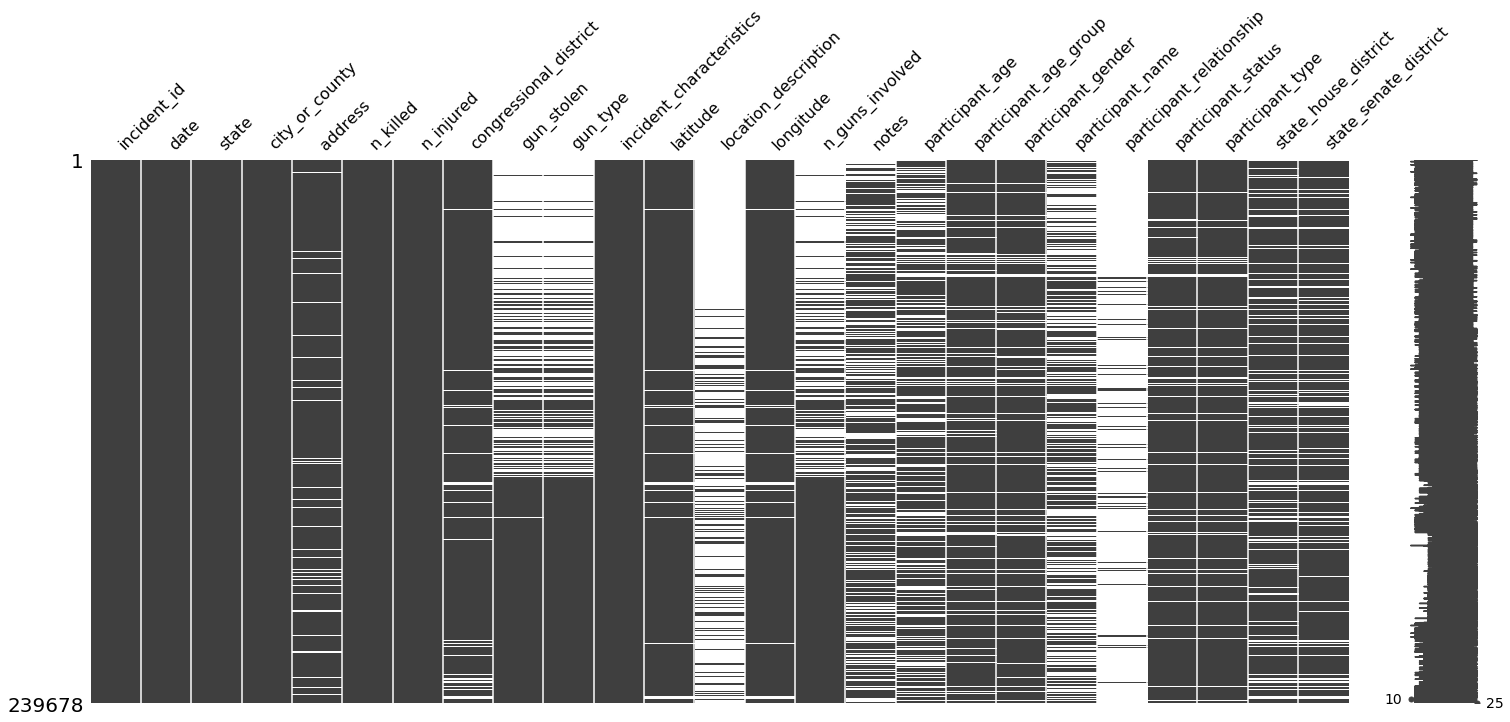

In [26]:
msno.matrix(incidents)

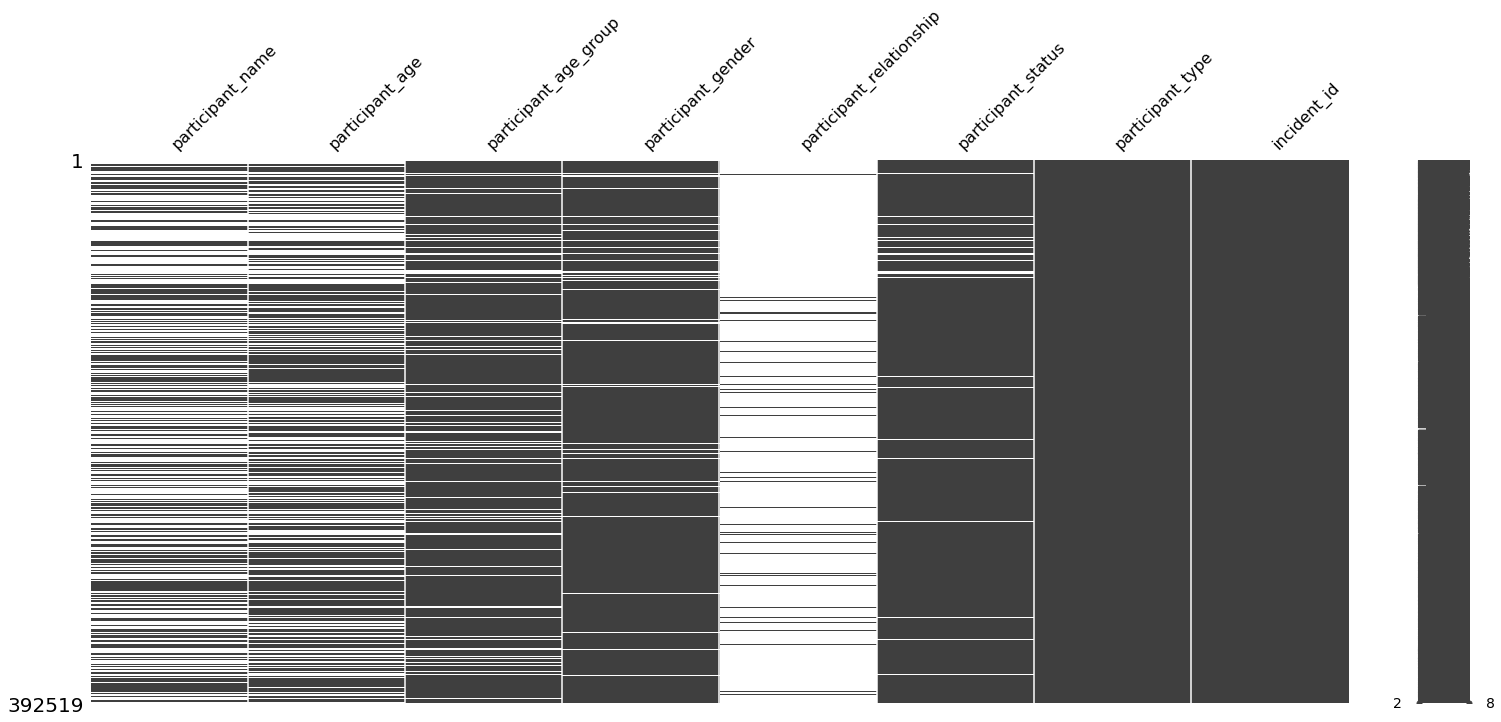

In [27]:
msno.matrix(participants)

In [28]:
incidents.drop(["gun_stolen", "gun_type", "participant_name", "participant_age", "participant_age_group", "participant_gender", "participant_relationship", "participant_status", "participant_type"], axis=1, inplace=True)

In [29]:
de.unique_values_table(incidents.drop("incident_characteristics", axis=1))

,address,city_or_county,congressional_district,date,incident_id,latitude,location_description,longitude,n_guns_involved,n_injured,n_killed,notes,state,state_house_district,state_senate_district
Unique,"188,498","12,898",54,"1,725","239,678","101,240","27,595","112,348",106,24,17,"136,653",51,275,68
Percentage,84.46,5.38,0.02,0.72,100,43.68,65.56,48.48,0.08,0.01,0.01,86.13,0.02,0.14,0.03


In [30]:
# Pearson's correlation coefficient
incidents.corr(method="pearson")

,incident_id,n_killed,n_injured,congressional_district,latitude,longitude,n_guns_involved,state_house_district,state_senate_district
incident_id,1.000000,0.005528,0.007803,-0.003590,0.019363,-0.017041,-0.029565,-0.002243,-0.007790
n_killed,0.005528,1.000000,0.097048,0.053650,-0.078088,-0.061354,-0.019808,-0.006015,-0.010650
n_injured,0.007803,0.097048,1.000000,-0.006103,-0.007564,0.020161,0.001932,-0.030355,-0.044294
congressional_district,-0.003590,0.053650,-0.006103,1.000000,-0.259486,-0.215597,0.021180,0.228827,0.309116
latitude,0.019363,-0.078088,-0.007564,-0.259486,1.000000,-0.056711,-0.001364,-0.237958,0.028611
longitude,-0.017041,-0.061354,0.020161,-0.215597,-0.056711,1.000000,-0.016227,0.236450,0.113408
n_guns_involved,-0.029565,-0.019808,0.001932,0.021180,-0.001364,-0.016227,1.000000,-0.003324,0.004247
state_house_district,-0.002243,-0.006015,-0.030355,0.228827,-0.237958,0.236450,-0.003324,1.000000,0.431299
state_senate_district,-0.007790,-0.010650,-0.044294,0.309116,0.028611,0.113408,0.004247,0.431299,1.000000


In [31]:
# Check dates with missing incidents
pd.date_range(start = '2014-01-01', end = '2018-03-31' ).difference(incidents.date)

DatetimeIndex(['2015-04-21', '2016-06-17', '2017-01-24'], dtype='datetime64[ns]', freq=None)

## Mass shootings separation

Following the observation that the recorded incidents of 2013 have been considerably lower than in subsequent years and predominantly mass shootings, the decision to only cover them for mass shooting analysis had been made.

In [32]:
print("Total number of incidents recorded in 2013: \t"+ str(len(incidents[incidents["date"].dt.year == 2013])))
print("Average number of incidents recorded (2014-17): " + str(round(len(incidents[incidents["date"].dt.year.between(2014, 2018)]) / 4)))

Total number of incidents recorded in 2013: 	278
Average number of incidents recorded (2014-17): 59850


In [33]:
victims_2013 = de.victims_by_year(incidents, 2013)

In [34]:
# TODO calculate mass shootings by looking at incidents
print("Total number of mass shootings in 2013: " + str(len([n_victims for n_victims in victims_2013 if n_victims >= 4])))
print("Total number of incidents in 2013: \t" + str(len(victims_2013)))

Total number of mass shootings in 2013: 259
Total number of incidents in 2013: 	278


In [35]:
# Create a mass shooting dataset for further analysis an remove the 2013 incidents from the dataset
mass_shootings = incidents[(incidents["n_killed"] + incidents["n_injured"]) >= 4]
incidents = incidents[incidents["date"].dt.year != 2013]

# Data Visualisation

## Feature distribution

### n_killed

In [38]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from dateutil import rrule
import calendar
import collections
from collections import Counter
from datetime import timedelta as td
from itertools import islice
import altair as alt
alt.renderers.enable('notebook')

mpl.style.use('default')

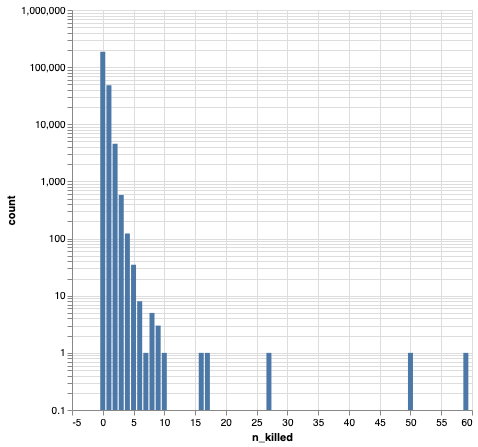

In [39]:
death_stats = incidents.groupby("n_killed").count().reset_index().loc[:, ["n_killed", "date"]]
death_stats.columns = ["n_killed", "count"]

alt.Chart(death_stats).mark_bar().encode(
    alt.X("n_killed"),
    alt.Y("count", scale=alt.Scale(padding=1, type="log")),
    alt.Tooltip('count')
).interactive().properties(height=400)

### n_injured

In [ ]:
injury_stats = incidents.groupby("n_injured").count().reset_index().loc[:, ["n_injured", "date"]]
injury_stats.columns = ["n_injured", "count"]

alt.Chart(injury_stats).mark_bar().encode(
    alt.X("n_injured"),
    alt.Y("count", scale=alt.Scale(padding=1, type="log")),
    alt.Tooltip('count')
).interactive().properties(width=800, height=400)

### n_guns_involved

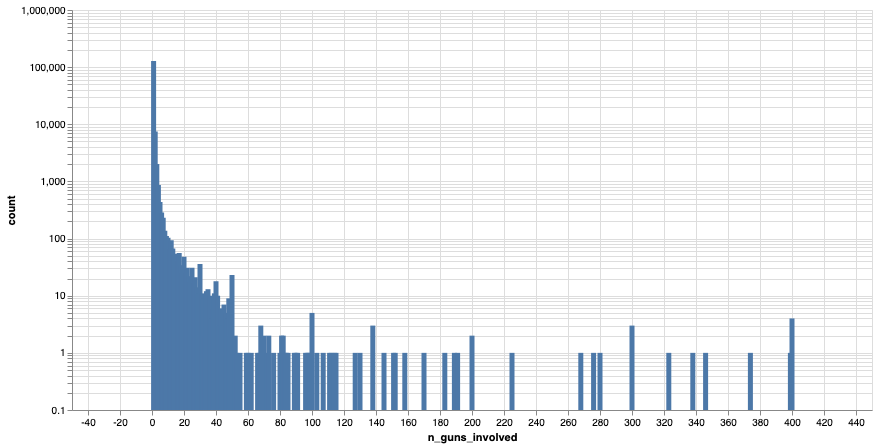

In [152]:
guns_stats = incidents.groupby("n_guns_involved").count().reset_index().loc[:, ["n_guns_involved", "date"]]
guns_stats.columns = ["n_guns_involved", "count"]

alt.Chart(guns_stats).mark_bar().encode(
    alt.X("n_guns_involved"),
    alt.Y("count", scale=alt.Scale(padding=1, type="log")),
    alt.Tooltip('count')
).interactive().properties(width=800, height=400)

### n_injured per gun type

In [147]:
gun_type_effectiveness = guns.set_index('incident_id').join(incidents.set_index('incident_id')[["n_killed", "n_injured"]]).groupby("type").sum().reset_index().loc[:, ["type", "n_killed", "n_injured"]]

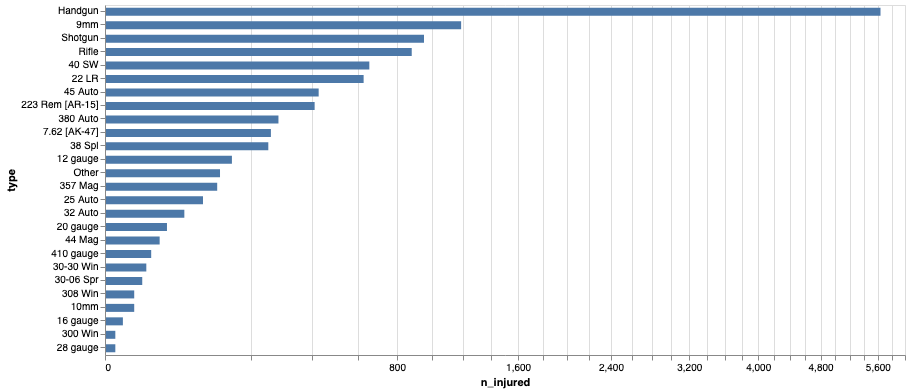

In [148]:
alt.Chart(gun_type_effectiveness[gun_type_effectiveness.type != "Unknown"]).mark_bar(height=8).encode(
    alt.Y("type:N", sort=alt.EncodingSortField(field="n_injured", order='descending')),
    alt.X("n_injured:Q", scale=alt.Scale(type="sqrt")),
    alt.Tooltip("n_injured")
).interactive().properties(width=800, height=350)

### n_killed per gun type

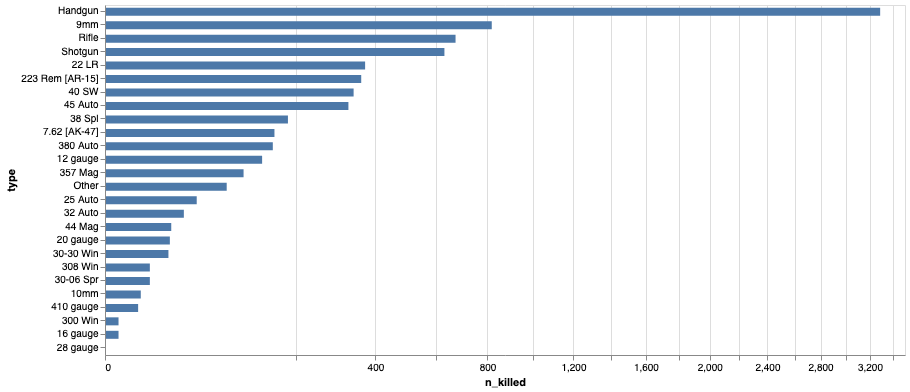

In [149]:
alt.Chart(gun_type_effectiveness[gun_type_effectiveness.type != "Unknown"]).mark_bar(height=8).encode(
    alt.Y("type:N", sort=alt.EncodingSortField(field="n_killed", order='descending')),
    alt.X("n_killed:Q", scale=alt.Scale(type="sqrt")),
    alt.Tooltip("n_killed")
).interactive().properties(width=800, height=350)

## Records over time

In [32]:
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 
          'October', 'November', 'December']
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
holidays = {"New Year's Day": dt(2000, 1, 1), "Martin Luther King, Jr. Day": dt(2000, 1, 21), 
            "George Washington’s Birthday": dt(2000, 2, 18), "Memorial Day": dt(2000, 5, 27),
            "Independence Day": dt(2000, 7, 4), "Labor Day": dt(2000, 9, 2), "Columbus Day": dt(2000, 10, 14),
            "Veterans Day": dt(2000, 11, 11), "Thanksgiving Day": dt(2000, 11, 28), "Christmas Day": dt(2000, 12, 25)}

### Number of casualties per year (2014-2018)

In [33]:
n_incidents_by_year = pd.DataFrame(df.groupby(df.date.dt.year).count().loc[:, "date"])
n_incidents_by_year.columns = ["n_incidents"]
n_casualties_by_year = pd.DataFrame(df.groupby(df.date.dt.year).sum().loc[:, ["n_killed", "n_injured"]])
stats_by_year = pd.concat([n_casualties_by_year, n_incidents_by_year], axis=1)
stats_by_year.index.name = "year"
stats_by_year = stats_by_year.reset_index()

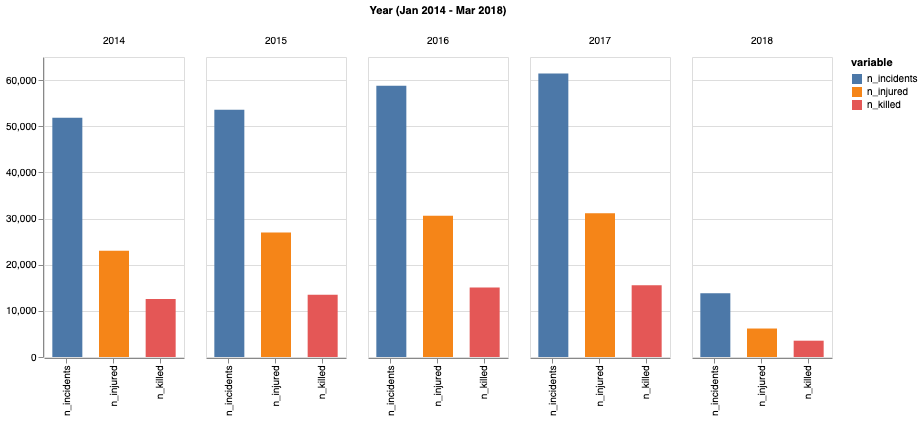

In [34]:
alt.Chart(stats_by_year.melt("year")).mark_bar(size=30).encode(
    alt.X("variable:N", axis=alt.Axis(title='')),
    alt.Y("value:Q", axis=alt.Axis(title='')),
    alt.Tooltip('value:Q'),
    alt.Color("variable:N"),
    alt.Column("year", title="Year (Jan 2014 - Mar 2018)")
).properties(width=140)

### Number of incidents by month (2014-2018)

In [35]:
n_incidents_by_month = df.groupby([df.date.dt.year, df.date.dt.month]).count().loc[:,"date"]
# Divide number of incidents for each month by the number of days
for date in rrule.rrule(rrule.MONTHLY, dtstart=dt(2014, 1, 1), until=dt(2018, 3, 1)):
    n_incidents_by_month[date.year][date.month] = n_incidents_by_month[date.year][date.month] / calendar.monthrange(date.year, date.month)[1]
# Average month values over all years
incidents_by_month_ave = pd.DataFrame(n_incidents_by_month).groupby(n_incidents_by_month.index.get_level_values(1)).sum() // pd.DataFrame(n_incidents_by_month).groupby(n_incidents_by_month.index.get_level_values(1)).count()

In [36]:
n_incidents_by_month = pd.DataFrame(n_incidents_by_month)
n_incidents_by_month.index.names = ["year", "month"]
n_incidents_by_month.columns = ["n_incidents"]
n_incidents_by_month = n_incidents_by_month.reset_index()

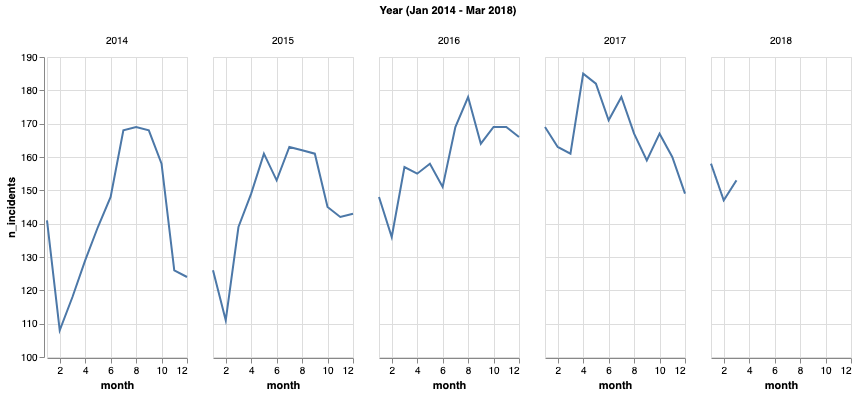

In [37]:
alt.Chart(n_incidents_by_month).mark_line().encode(
    alt.X("month"),
    alt.Y("n_incidents", scale=alt.Scale(zero=False)),
    alt.Column("year", title="Year (Jan 2014 - Mar 2018)"),
    alt.Tooltip('n_incidents:Q')
).properties(width=140)

### Average number of incidents by month

In [38]:
incidents_by_month_ave.index = months
incidents_by_month_ave = incidents_by_month_ave.reset_index().reset_index()
incidents_by_month_ave.columns = ["order", "month", "n_incidents"]

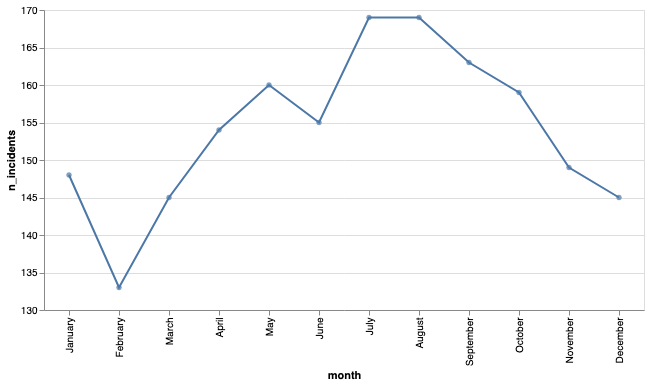

In [39]:
month_chart = alt.Chart(incidents_by_month_ave).mark_line().encode(
    alt.X("month:N", sort=None),
    alt.Y("n_incidents:Q", scale=alt.Scale(zero=False)),
    alt.Tooltip('n_incidents:Q'),
    alt.Order("order")
).properties(width=600, height=300)

month_chart + month_chart.mark_circle()

### Average number of incidents by date

In [40]:
n_incidents_by_date = df.groupby(df.date.dt.date).count().loc[:, "date"]
# Average date values over all years
n_records_by_date = pd.DataFrame(df.groupby([df.date.dt.year, df.date.dt.month, df.date.dt.day, df.date.dt.weekday]).count().loc[:, "date"])
n_avg_killed_by_date = pd.DataFrame(df.groupby([df.date.dt.month, df.date.dt.day]).sum().loc[:, "n_killed"]) // n_records_by_date.groupby([n_records_by_date.index.get_level_values(1), n_records_by_date.index.get_level_values(2)]).count().rename(columns={"date":"n_killed"})
n_avg_injured_by_date = pd.DataFrame(df.groupby([df.date.dt.month, df.date.dt.day]).sum().loc[:, "n_injured"]) // n_records_by_date.groupby([n_records_by_date.index.get_level_values(1), n_records_by_date.index.get_level_values(2)]).count().rename(columns={"date":"n_injured"})
n_avg_incidents_by_date = pd.DataFrame(df.groupby([df.date.dt.month, df.date.dt.day]).count().loc[:, "date"]) // n_records_by_date.groupby([n_records_by_date.index.get_level_values(1), n_records_by_date.index.get_level_values(2)]).count()

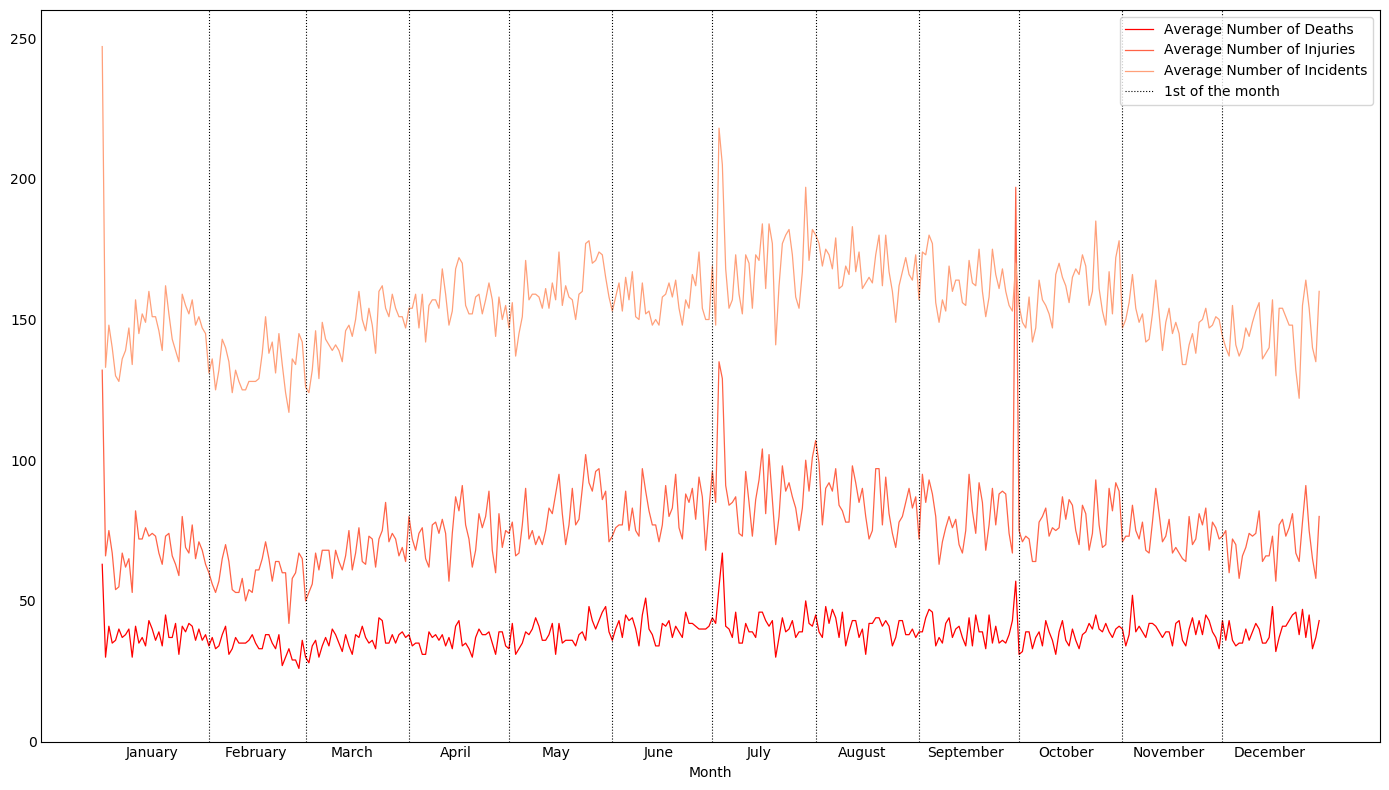

In [41]:
fig, ax = plt.subplots(figsize=(14, 8))
ax.plot(np.arange(366), n_avg_killed_by_date, label='Average Number of Deaths', color='red', linewidth=0.9)
ax.plot(np.arange(366), n_avg_injured_by_date, label='Average Number of Injuries', color='tomato', linewidth=0.9)
ax.plot(np.arange(366), n_avg_incidents_by_date, label='Average Number of Incidents', color='lightsalmon', linewidth=0.9)
ax.set_ylim([0, 260])
ax.set_xlabel("Month")
plt.setp(ax, xticks=[dt(2000, 1, 15).timetuple().tm_yday, dt(2000, 2, 15).timetuple().tm_yday, dt(2000, 3, 15).timetuple().tm_yday, dt(2000, 4, 15).timetuple().tm_yday, dt(2000, 5, 15).timetuple().tm_yday, dt(2000, 6, 15).timetuple().tm_yday, dt(2000, 7, 15).timetuple().tm_yday, dt(2000, 8, 15).timetuple().tm_yday, dt(2000, 9, 15).timetuple().tm_yday, dt(2000, 10, 15).timetuple().tm_yday, dt(2000, 11, 15).timetuple().tm_yday, dt(2000, 12, 15).timetuple().tm_yday], xticklabels=months)
for month in range(2, 13):
    mline = ax.axvline(dt(2000, month, 1).timetuple().tm_yday, color='black', linestyle=':', linewidth=0.8)
mline.set_label('1st of the month')
ax.tick_params(axis=u'both', which=u'both',length=0)
plt.legend(loc='upper right')
fig.tight_layout()
plt.show()

### Most dangerous dates for gun crime

In [42]:
n_avg_incidents_by_date = dict()
sd = dt.strptime('2000-01-01','%Y-%m-%d'); ed = dt.strptime('2000-12-31','%Y-%m-%d')
delta = ed - sd
for i in range(delta.days+1):
    n_avg_incidents_by_date[sd + td(days = i)] = 0
# Populate dictionary
for k, v in dict(n_incidents_by_date).items():
    n_avg_incidents_by_date[dt(2000, k.month, k.day)] += v
for key in n_avg_incidents_by_date.keys():
    if key.month in range(1, 4):
        if (key.month == 2) and (key.day == 29):
            pass
        else:
            n_avg_incidents_by_date[key] /= 5
    else:
        n_avg_incidents_by_date[key] /= 4

In [43]:
n_incidents_by_date = dict(sorted(n_incidents_by_date.items(), key=lambda kv: kv[1], reverse=True))
n_avg_incidents_by_date = dict(sorted(n_avg_incidents_by_date.items(), key=lambda kv: kv[1], reverse=True))

In [44]:
def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

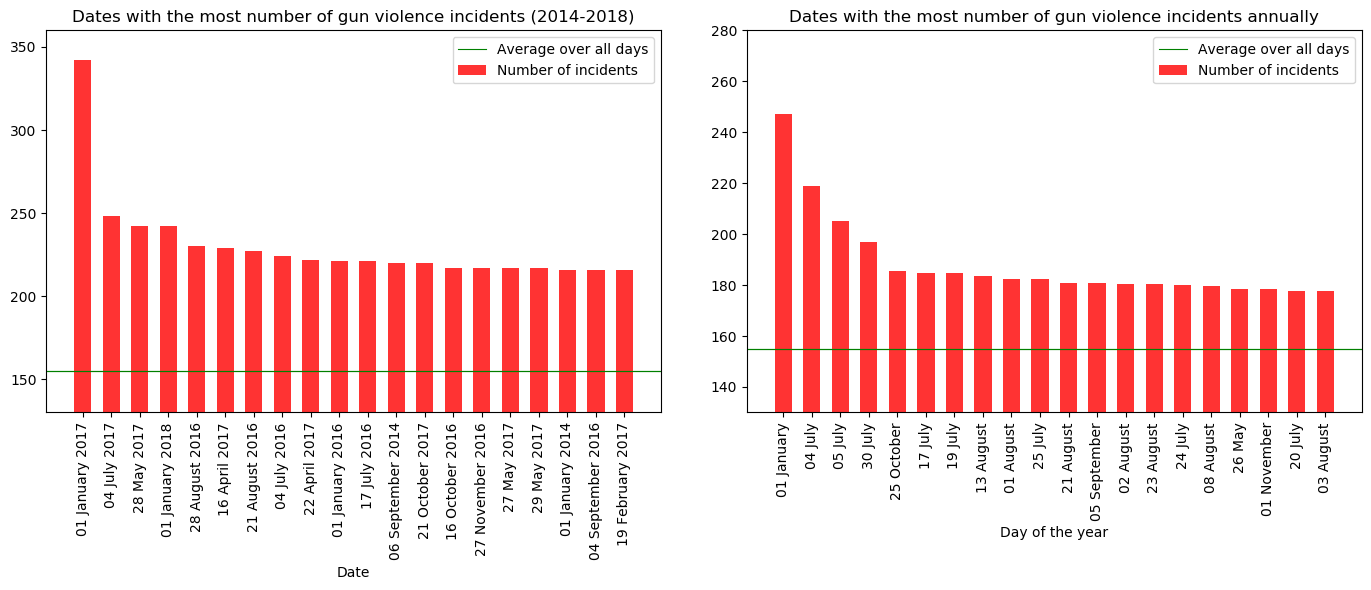

In [45]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
ax[0].bar(np.arange(20), [x[1] for x in take(20, n_incidents_by_date.items())], alpha=0.8, label='Number of incidents', width=0.6, align='center', color='red')
ax[1].bar(np.arange(20), [x[1] for x in take(20, n_avg_incidents_by_date.items())], alpha=0.8, label='Number of incidents', width=0.6, align='center', color='red')
ax[0].axhline(sum(n_avg_incidents_by_date.values()) / 366, color='green', linestyle='-', linewidth=0.8)
ax[1].axhline(sum(n_avg_incidents_by_date.values()) / 366, color='green', linestyle='-', linewidth=0.8)
ax[0].axhline(sum(n_avg_incidents_by_date.values()) / 366, label='Average over all days', color='green', linestyle='-', linewidth=0.8)
ax[1].axhline(sum(n_avg_incidents_by_date.values()) / 366, label='Average over all days', color='green', linestyle='-', linewidth=0.8)
ax[0].set_xlabel("Date")
ax[1].set_xlabel("Day of the year")
ax[0].set_title("Dates with the most number of gun violence incidents (2014-2018)")
ax[1].set_title("Dates with the most number of gun violence incidents annually")
ax[0].set_ylim([130, 360])
ax[1].set_ylim([130, 280])
plt.sca(ax[0])
plt.xticks(np.arange(20), ['{0:%d} {0:%B} {0:%Y}'.format(x[0], "day", "month", "year") for x in take(20, n_incidents_by_date.items())], rotation=90)
plt.legend(loc='upper right')
plt.sca(ax[1])
plt.xticks(np.arange(20), ['{0:%d} {0:%B}'.format(x[0], "day", "month") for x in take(20, n_avg_incidents_by_date.items())], rotation=90)
plt.legend(loc='upper right')
fig.tight_layout()
plt.show()

### Gun crime statistics on federal holidays and weekends

In [46]:
n_incidents_by_weekday = pd.DataFrame(df.groupby(df.date.dt.weekday).count().loc[:, "date"])
n_incidents_by_weekday = n_incidents_by_weekday // n_records_by_date.groupby(n_records_by_date.index.get_level_values(3)).count()

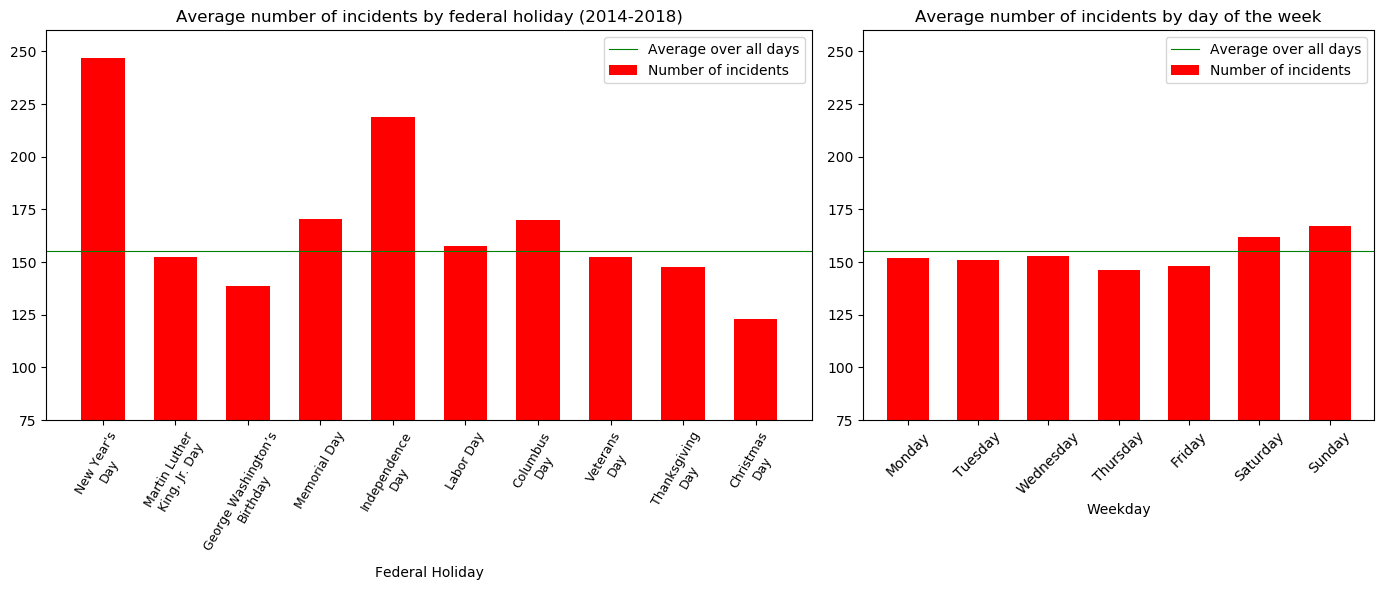

In [47]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={'width_ratios': [1.5, 1]})
ax[0].bar(np.arange(len(holidays)), [n_avg_incidents_by_date[v] for k, v in holidays.items()], label='Number of incidents', width=0.6, align='center', color='red')
ax[1].bar(np.arange(len(weekdays)), [x[1] for x in n_incidents_by_weekday["date"].items()], label='Number of incidents', width=0.6, align='center', color='red')
ax[0].axhline(sum(n_avg_incidents_by_date.values()) / 366, label='Average over all days', color='green', linestyle='-', linewidth=0.8)
ax[1].axhline(sum(n_avg_incidents_by_date.values()) / 366, label='Average over all days', color='green', linestyle='-', linewidth=0.8)
ax[0].set_xlabel("Federal Holiday")
ax[1].set_xlabel("Weekday")
ax[0].set_title("Average number of incidents by federal holiday (2014-2018)")
ax[1].set_title("Average number of incidents by day of the week")
ax[0].set_ylim([75, 260])
ax[1].set_ylim([75, 260])
plt.sca(ax[0])
plt.xticks(range(0, len(holidays)), ["New Year's\nDay", 'Martin Luther\nKing, Jr. Day', 'George Washington’s\nBirthday', 'Memorial Day', 'Independence\nDay', 'Labor Day', 'Columbus\nDay', 'Veterans\nDay', 'Thanksgiving\nDay', 'Christmas\nDay'], rotation=60, fontsize = 9)
plt.legend(loc='upper right')
plt.sca(ax[1])
plt.xticks(range(0, 7), weekdays, rotation=45)
plt.legend(loc='upper right')
fig.tight_layout()
plt.show()

## State

In [48]:
from vega_datasets import data

In [49]:
states = ["Alabama", "Alaska", "Arizona", "Arkansas", "California", "Colorado", "Connecticut", "District of Columbia", "Delaware", "Florida", "Georgia", "Hawaii", "Idaho", "Illinois", "Indiana", "Iowa", "Kansas", "Kentucky", "Louisiana", "Maine", "Maryland", "Massachusetts", "Michigan", "Minnesota", "Mississippi", "Missouri", "Montana", "Nebraska", "Nevada", "New Hampshire", "New Jersey", "New Mexico", "New York", "North Carolina", "North Dakota", "Ohio", "Oklahoma", "Oregon", "Pennsylvania", "Rhode Island", "South Carolina", "South Dakota", "Tennessee", "Texas", "Utah", "Vermont", "Virginia", "Washington", "West Virginia", "Wisconsin", "Wyoming"]
state_abbreviations = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]
state_population = {'Alabama': 4853193, 'Alaska': 738438, 'Arizona': 6839353, 'Arkansas': 2979818, 'California': 38893516, 'Colorado': 5446126, 'Connecticut': 3585952, 'District of Columbia': 940788, 'Delaware': 674093, 'Florida': 20250908, 'Georgia': 10188251, 'Hawaii': 1419621, 'Idaho': 1659273, 'Illinois': 12852933, 'Indiana': 6612724, 'Iowa': 3119893, 'Kansas': 2905172, 'Kentucky': 4427480, 'Louisiana': 4656533, 'Maine': 1330774, 'Maryland': 5979634, 'Massachusetts': 6792551, 'Michigan': 9940970, 'Minnesota': 5487856, 'Mississippi': 2989215, 'Missouri': 6072902, 'Montana': 1031982, 'Nebraska': 1891988, 'Nevada': 2871365, 'New Hampshire': 1337613, 'New Jersey': 8871814, 'New Mexico': 2091906, 'New York': 19635618, 'North Carolina': 10047620, 'North Dakota': 744586, 'Ohio': 11619306, 'Oklahoma': 3900162, 'Oregon': 4028386, 'Pennsylvania': 12785093, 'Rhode Island': 1056172, 'South Carolina': 4891931, 'South Dakota': 856293, 'Tennessee': 6595774, 'Texas': 27442726, 'Utah': 2992711, 'Vermont': 624959, 'Virginia': 8360838, 'Washington': 7179800, 'West Virginia': 1838663, 'Wisconsin': 5763068, 'Wyoming': 582713}

In [50]:
casualties_by_state = df.groupby("state").sum()["n_injured"] + df.groupby("state").sum()["n_killed"]
casualties_by_state = pd.DataFrame(casualties_by_state).reset_index().reset_index()
casualties_by_state.columns = ["id", "state", "n_casualties"]
casualties_by_state["id"] = [1, 2, 4, 5, 6, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 49, 50, 51, 53, 54, 55, 56]

incidents_by_state = df.groupby("state").count()["date"]
incidents_by_state = pd.DataFrame(incidents_by_state).reset_index().reset_index()
incidents_by_state.columns = ["id", "state", "n_incidents"]
incidents_by_state["id"] = [1, 2, 4, 5, 6, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 49, 50, 51, 53, 54, 55, 56]

In [51]:
us_map = alt.topo_feature(data.us_10m.url, 'states')

In [52]:
# TODO show state name and count when hovering

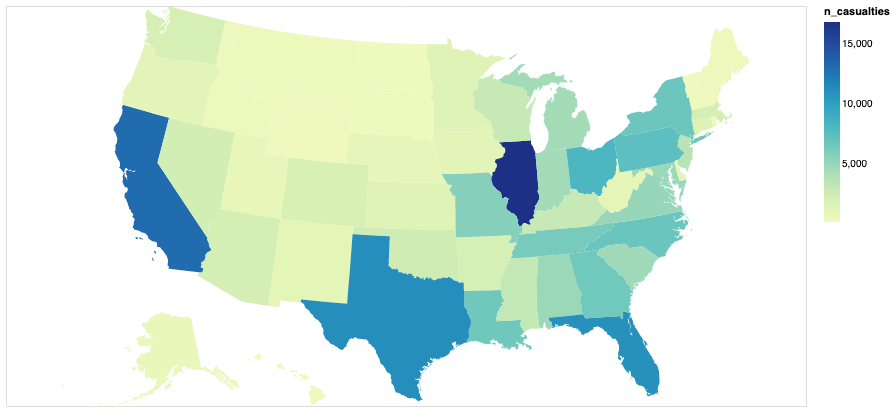

In [53]:
alt.Chart(us_map).mark_geoshape().encode(
    alt.Color(alt.repeat('row'), type='quantitative')
).transform_lookup(
    lookup='id',
    from_=alt.LookupData(casualties_by_state, 'id', ["n_casualties"])
).properties(
    width=800,
    height=400
).project(
    type='albersUsa'
).repeat(
    row=['n_casualties']
).resolve_scale(
    color='independent'
)

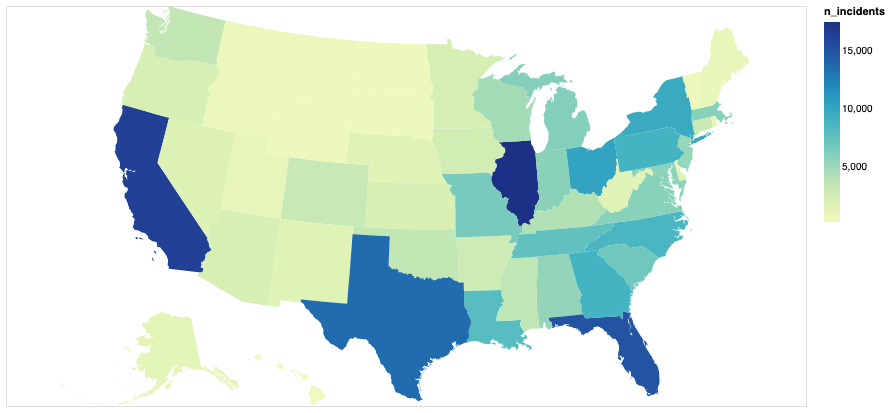

In [54]:
alt.Chart(us_map).mark_geoshape().encode(
    alt.Color(alt.repeat('row'), type='quantitative')
).transform_lookup(
    lookup='id',
    from_=alt.LookupData(incidents_by_state, 'id', ["n_incidents"])
).properties(
    width=800,
    height=400
).project(
    type='albersUsa'
).repeat(
    row=['n_incidents']
).resolve_scale(
    color='independent'
)

In [59]:
casualties_per_capita = casualties_by_state.copy()
incidents_per_capita = incidents_by_state.copy()
for i in range(0, 51):
    casualties_per_capita.at[i, "n_casualties"] = round(casualties_per_capita.loc[i]["n_casualties"]*100000 / state_population[casualties_per_capita.loc[i]["state"]], 1)
    incidents_per_capita.at[i, "n_incidents"] = round(incidents_per_capita.loc[i]["n_incidents"]*100000 / state_population[incidents_per_capita.loc[i]["state"]], 1)
    
casualties_per_capita.columns = ["id", "state", "n_casualties_per_capita"]
incidents_per_capita.columns = ["id", "state", "n_incidents_per_capita"]

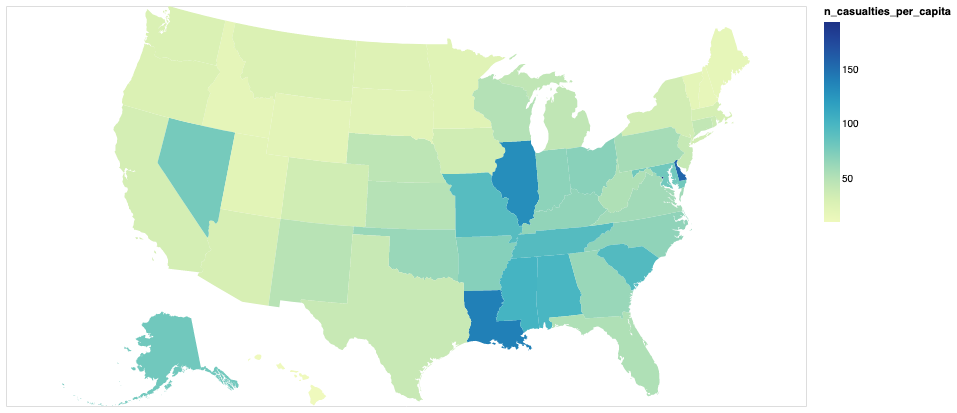

In [60]:
alt.Chart(us_map).mark_geoshape().encode(
    alt.Color(alt.repeat('row'), type='quantitative')
).transform_lookup(
    lookup='id',
    from_=alt.LookupData(casualties_per_capita, 'id', ["n_casualties_per_capita"])
).properties(
    width=800,
    height=400
).project(
    type='albersUsa'
).repeat(
    row=['n_casualties_per_capita']
).resolve_scale(
    color='independent'
)

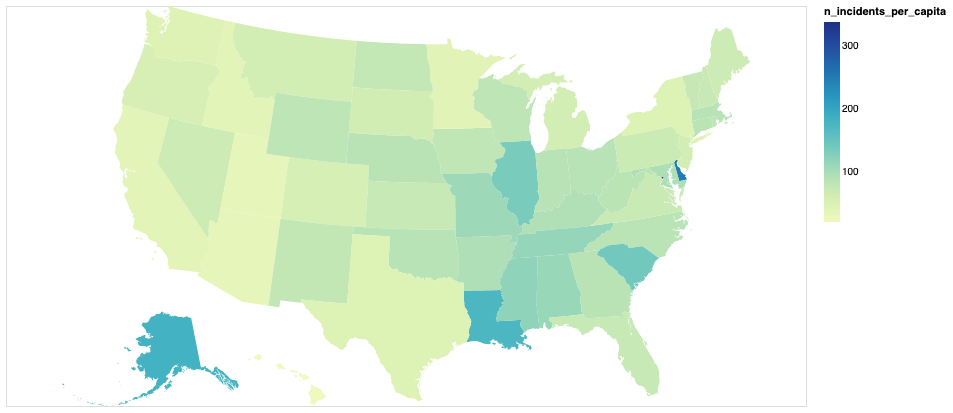

In [61]:
alt.Chart(us_map).mark_geoshape().encode(
    alt.Color(alt.repeat('row'), type='quantitative')
).transform_lookup(
    lookup='id',
    from_=alt.LookupData(incidents_per_capita, 'id', ["n_incidents_per_capita"])
).properties(
    width=800,
    height=400
).project(
    type='albersUsa'
).repeat(
    row=['n_incidents_per_capita']
).resolve_scale(
    color='independent'
)

## Cities

### Cities with most gun violence incidents

### Cities with most gun violence incidents per capita

### Map of gun violence incidents

## Address

### Addresses with most gun crimes

### Map with addresses with most gun violence

## Nr killed/injured

### Pie chart with number of people killed/injured/casualties

### Maybe number of casualties over time

### Maybe incident characteristics/location description too

### Maybe gun type too

### Nr killed/injured by gender of suspect